In [23]:
from google.colab import drive
drive.mount('/content/drive')
 
%matplotlib inline
%matplotlib notebook

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import json
import random
import linecache
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.close('all')
torch.manual_seed(1)

%cd drive/My\ Drive/ANLP/A1
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/ANLP/A1'
/content/drive/My Drive/ANLP/A1
/content/drive/My Drive/ANLP/A1


### Load the saved vocabulary and keep only those words which have frequency > 5

In [2]:
with open('unique_words.json', 'r') as pf:
    unique_words_dict = json.load(pf)

print(len(unique_words_dict))
# print(unique_words_dict)

unique_words_dict = {key:val for key, val in unique_words_dict.items() if val > 5}
print(len(unique_words_dict))

total_sentences = 0
with open('meta.txt', 'r') as mf:
    total_sentences = int(mf.readline().strip())
print(total_sentences)

378343
69720
12317739


### Map words to index and vice versa

In [3]:
word2index = {w:idx for idx, w in enumerate(unique_words_dict)}
index2word = {idx:w for idx, w in enumerate(unique_words_dict)}

total_words = len(word2index)
print(total_words)
print(word2index["very"])
print(index2word[65873])

69720
65873
very


### CBOW model architecture

In [4]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.EmbeddingBag(vocab_size, embedding_dim, mode='sum')
        self.proj = nn.Linear(embedding_dim, 128)
        self.output = nn.Linear(128, vocab_size)
        
    def forward(self, inputs, offsets):
        embeds = self.embeddings(inputs, offsets)
        out = F.relu(self.proj(embeds))
        out = self.output(out)
        nll_prob = F.log_softmax(out, dim=-1)
        return nll_prob

### Set embedding size, window size, batch size and initialize CBOW model and optimizer

In [5]:
embed_dim = 64
window_size = 4  ## {w_i-4 ... w_i ... w_i+4}
model = CBOW(total_words, embed_dim).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss().cuda()
batch = 10  ## no. of sentences
checkpoint = torch.load("models/cbow_be0.pth")
model.load_state_dict(checkpoint['cbow_net'])
optimizer.load_state_dict(checkpoint['optimizer'])

### CBOW dataloader and training script  
Randomly picking sentences from the processed reviews file for training in batches of 10 sentences with variable number of context vectors per sentence (formed using sliding window)

In [6]:
def prepare_batch(batch_sents):
    global word2index, window_size
    targets = []
    contexts = []
    offsets = []
    off = 0
    for sent in batch_sents:
        words = [w for w in sent.split() if w in word2index]
        if len(words) <= 1:
            continue
        for i, w in enumerate(words):
            context = []
            targets.append(word2index[w])  ## center word for current window
            for x in range(max(i-window_size,0), i):  ## sliding window
                context.append(word2index[words[x]])
            for x in range(i+1, min(i+window_size+1, len(words))):
                context.append(word2index[words[x]])
            contexts.extend(context)
            offsets.append(off) ## start position (offset) of current window needed for nn.EmbeddingBag layer
            off += len(context)
    return contexts, targets, offsets


for epoch in range(1,10):
    print("\nepoch",epoch)
    line_nums = list(range(1,total_sentences+1))  ## shuffle line numbers to pick random sentences
    random.shuffle(line_nums)
    b = 1
    epoch_loss = 0
    l = 0
    cur_lines = []
    for line_no in line_nums:
        l += 1
        cur_lines.append(linecache.getline('processed_reviews.txt',line_no).strip())  ## read the sentence at line_no
        if l%batch != 0:
            continue
        batch_contexts, batch_targets, batch_offsets = prepare_batch(cur_lines)
        batch_contexts = torch.tensor(batch_contexts).cuda()
        batch_targets = torch.tensor(batch_targets).cuda()
        batch_offsets = torch.tensor(batch_offsets).cuda()
        model.zero_grad()
        nll_prob = model(batch_contexts,batch_offsets)
        loss = loss_func(nll_prob, batch_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        cur_lines = []
        if b%100 == 0:
            print("batch",b,"\tloss",epoch_loss/b)
            torch.save({
            'cbow_net' : model.state_dict(),
            'optimizer' : optimizer.state_dict(),
            }, 'models/cbow_be{}.pth'.format(epoch))
        b += 1
    torch.save({
        'cbow_net' : model.state_dict(),
        'optimizer' : optimizer.state_dict(),
        }, 'models/cbow_be{}.pth'.format(epoch))
    epoch_loss /= b
    print("epoch_loss",epoch_loss)



epoch 1
batch 100 	loss 6.29891727924347
batch 200 	loss 6.319207808971405
batch 300 	loss 6.326361608505249
batch 400 	loss 6.330655690431595
batch 500 	loss 6.327445034027099
batch 600 	loss 6.331887309551239
batch 700 	loss 6.3281196056093485
batch 800 	loss 6.321264601349831
batch 900 	loss 6.317926917076111
batch 1000 	loss 6.317328639507294
batch 1100 	loss 6.308169255256653
batch 1200 	loss 6.308143789370854
batch 1300 	loss 6.305646112882174
batch 1400 	loss 6.303182029383523
batch 1500 	loss 6.2994546159108475
batch 1600 	loss 6.297347390949726
batch 1700 	loss 6.297117444206687
batch 1800 	loss 6.298524746365017
batch 1900 	loss 6.2984249305725095
batch 2000 	loss 6.296866994857788
batch 2100 	loss 6.297599946203686
batch 2200 	loss 6.295126012888821
batch 2300 	loss 6.29604303214861
batch 2400 	loss 6.2964014319578805
batch 2500 	loss 6.294194060897827
batch 2600 	loss 6.295185435918661
batch 2700 	loss 6.29411712664145
batch 2800 	loss 6.293209842954363
batch 2900 	loss 6.

### Find 10 most similar words to 'camera' from the vocabulary using L2 distance measure between learned embeddings

In [25]:
test_model = CBOW(total_words, embed_dim).cuda()
checkpoint = torch.load("models/cbow_be1.pth")
test_model.load_state_dict(checkpoint['cbow_net'])

def get_similar_words(X, word, k=11):
    global index2word
    idx = word2index[word]
    dists = np.dot((X - X[idx]) ** 2, np.ones(X.shape[1]))
    idxs = np.argsort(dists)[:k]
    similar_words = []
    for i in idxs:
        similar_words.append(index2word[i])
    return similar_words

embed_matrix = test_model.embeddings.weight.detach().cpu().numpy()
sim_words = get_similar_words(embed_matrix,"camera")
print("Our CBOW model : Words similar to 'camera' are :",sim_words)

import gensim.downloader
glove_vectors = gensim.downloader.load('glove-twitter-50')
print("\nPre-trained Word2Vec : Words similar to 'camera' are :")
glove_vectors.most_similar('camera')

Our CBOW model : Words similar to 'camera' are : ['camera', 'unit', 'mouse', 'case', 'device', 'keyboard', 'cable', 'lens', 'tv', 'battery', 'tablet']

Pre-trained Word2Vec : Words similar to 'camera' are :


[('screen', 0.8736051321029663),
 ('display', 0.8128992319107056),
 ('cameras', 0.8059788346290588),
 ('monitor', 0.7853043079376221),
 ('computer', 0.7842990159988403),
 ('flash', 0.7833526730537415),
 ('desktop', 0.7727495431900024),
 ('case', 0.7712317109107971),
 ('dslr', 0.7634223103523254),
 ('zoom', 0.7560485005378723)]

### Plot similar words using TSNE for different categories of words (noun, verb, adjective)


Words similar to : person
['person', 'product', 'feature', 'same', 'camera', 'little', 'time', 'signal', 'battery', 'bad', 'headphones']

Words similar to : camera
['camera', 'unit', 'mouse', 'case', 'device', 'keyboard', 'cable', 'lens', 'tv', 'battery', 'tablet']

Words similar to : floor
['floor', 'button', 'box', 'cover', 'case', 'side', 'setup', 'head', 'bottom', 'mount', 'part']

Words similar to : truck
['truck', 'signal', 'number', 'system', 'part', 'head', 'removing', 'cover', 'screen', 'key', 'garmin']

Words similar to : television
['television', 'monitor', 'laptop', 'pc', 'mouse', 'cord', 'keyboard', 'motherboard', 'tv', 'desktop', 'device']

Words similar to : mounting
['mounting', 'most', 'now', 'still', 'control', 'absolutely', 'even', 'just', 'screen', 'all', 'very']

Words similar to : pull
['pull', 'turn', 'take', 'remove', 'keep', 'get', 'store', 'back', 'try', 'break', 'control']

Words similar to : replacing
['replacing', 'honestly', 'yes', 'now', 'three', 'almost

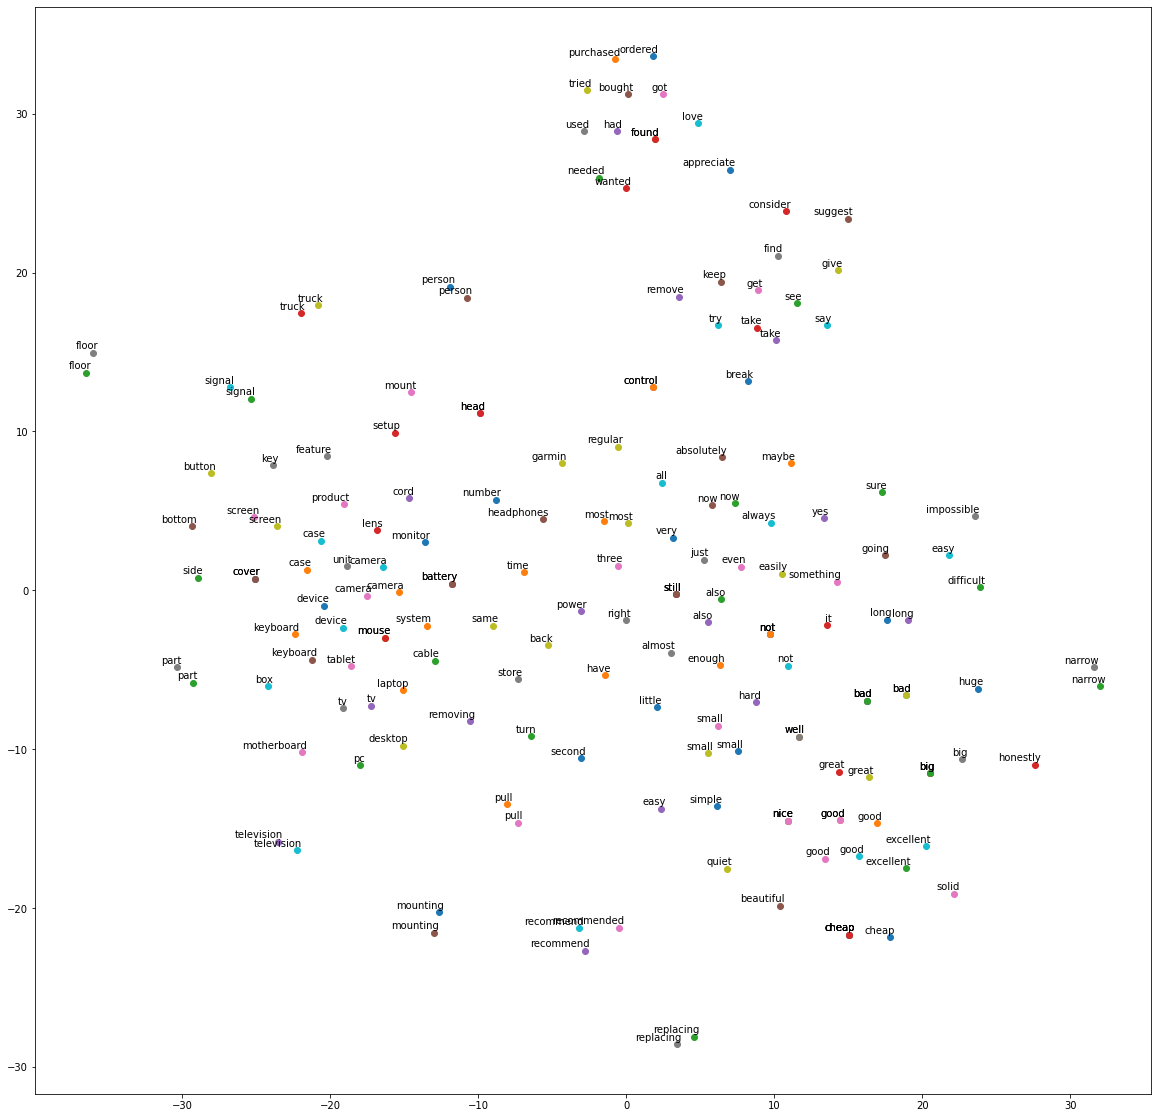

In [27]:
def tsne_plot(words_toplot):
    global embed_matrix
    labels = words_toplot.copy()
    for wp in words_toplot:
        print("\nWords similar to :",wp)
        sim_words = get_similar_words(embed_matrix,wp)
        print(sim_words)
        labels.extend(sim_words)
    tokens = []
    for lab in labels:
        idx = word2index[lab]
        tokens.append(embed_matrix[idx])
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1]) 
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

words_toplot = ['person', 'camera', 'floor', 'truck', 'television', 'mounting', 'pull', 'replacing', 'found', 'recommend', 'cheap', 'good', 'narrow', 'bad', 'easy']
tsne_plot(words_toplot)